# Convolutional Neural Networks

## Project: Landmark Classification with Transfer learning

In the previous notebook we have trained our own CNN and we got a certain performance. Let's see how hard it is to match that performance with transfer learning.

---
## Step 0: Setting up

The following cells make sure that your environment is setup correctly and check that your GPU is available and ready to go. You have to execute them every time you restart your notebook.

In [2]:
# Install requirements
!pip install -r requirements.txt | grep -v "already satisfied"

In [1]:
from src.helpers import setup_env

# If running locally, this will download dataset (make sure you have at 
# least 2 Gb of space on your hard drive)
setup_env()

GPU available
Dataset already downloaded. If you need to re-download, please delete the directory /data/DLND/C2/landmark_images
Reusing cached mean and std


---
## Step 1: Create transfer learning architecture

Test `get_model_transfer_learning` function located in `src/transfer.py`:

In [3]:
!pytest -vv src/transfer.py

============================= test session starts ==============================
platform linux -- Python 3.7.6, pytest-7.1.1, pluggy-1.2.0 -- /opt/conda/bin/python3.7
cachedir: .pytest_cache
rootdir: /workspace/home
collected 1 item                                                               

src/transfer.py::test_get_model_transfer_learning PASSED                 [100%]

============================== 1 passed in 5.75s ===============================


---
## Step 2: Train, validation and test

Training the transfer learning model! Let's start defining the hyperparameters:

In [4]:
batch_size = 64  # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.2  # fraction of the training data to reserve for validation
num_epochs = 50  # number of epochs for training
num_classes = 50  # number of classes. Do not change this
learning_rate = 0.001  # Learning rate for SGD (or Adam)
opt = 'adam'      # optimizer. 'sgd' or 'adam'
weight_decay = 0.0 # regularization. Increase this to combat overfitting

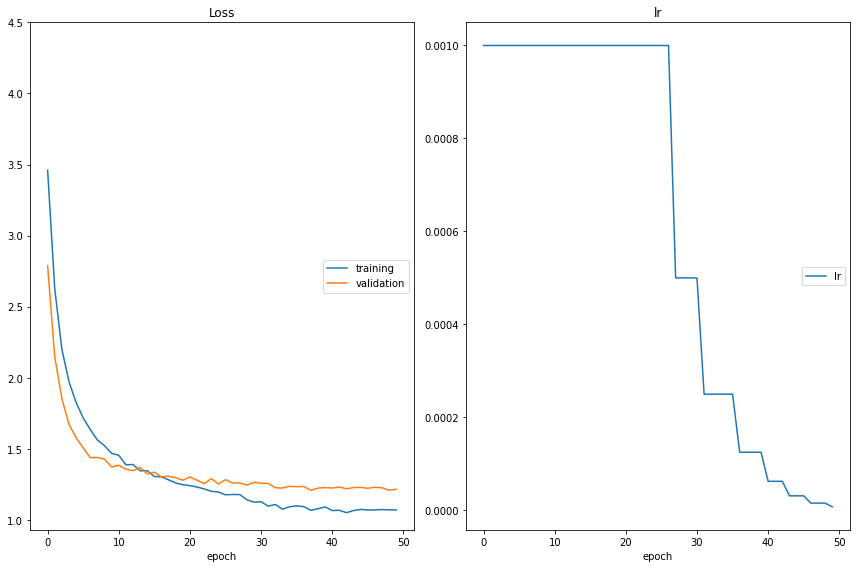

In [6]:
from src.data import get_data_loaders
from src.optimization import get_optimizer, get_loss
from src.train import optimize
from src.transfer import get_model_transfer_learning

# Get a model using get_model_transfer_learning. Use one of the names reported here:
# https://pytorch.org/vision/0.10/models.html
# For example, if you want to load ResNet 18, use "resnet18"
# NOTE: use the hyperparameters defined in the previous cell, do NOT copy/paste the
# values
model_transfer = get_model_transfer_learning(model_name="resnet18", n_classes=num_classes)

# train the model
data_loaders = get_data_loaders(batch_size=batch_size)
optimizer = get_optimizer(
    model_transfer,
    learning_rate=learning_rate,
    optimizer=opt,
    weight_decay=weight_decay,
)
loss = get_loss()

optimize(
    data_loaders,
    model_transfer,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path="checkpoints/model_transfer.pt",
    interactive_tracking=True
)

Outlining the steps tooken to get to my final CNN architecture and my reasoning at each step.  Describing why I think the architecture is suitable for the current problem.

Transfer learning improves accuracy even on limited data:
* ResNet18's pretrained filters give a strong head start. It's provides ideal balance between performance and computational efficiency, especially when training on limited hardware or smaller datasets.
* Freezing reduces the number of parameters to update.
* Final layer adapts the model to our specific task (50 classes).

Now play with the hyperparameters and see which performance you can get on the validation set. You should get at least 60% for a passing grade, but a good model choice and a good training strategy could get you up to 80% or so. Let's see how close you can get!

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 3: Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60% and matches more or less what you got on the validation set (otherwise you're overfitting!)

In [7]:
import torch
from src.train import one_epoch_test
from src.transfer import get_model_transfer_learning

model_transfer = get_model_transfer_learning("resnet18", n_classes=num_classes)
# Load saved weights
model_transfer.load_state_dict(torch.load('checkpoints/model_transfer.pt'))

one_epoch_test(data_loaders['test'], model_transfer, loss)

Testing: 100%|██████████████████████████████████| 20/20 [00:15<00:00,  1.27it/s]

Test Loss: 1.046867


Test Accuracy: 74% (930/1250)


1.0468665480613708

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 4: Export using torchscript

Now, just like we did with our original model, we export the best fit model using torchscript so that it can be used in our application:

In [8]:
from src.predictor import Predictor
from src.helpers import compute_mean_and_std

# First let's get the class names from our data loaders
class_names = data_loaders["train"].dataset.classes

# Then let's move the model_transfer to the CPU
# (we don't need GPU for inference)
model_transfer = model_transfer.cpu()
# Let's make sure we use the right weights by loading the
# best weights we have found during training
# NOTE: remember to use map_location='cpu' so the weights
# are loaded on the CPU (and not the GPU)
model_transfer.load_state_dict(
    torch.load("checkpoints/model_transfer.pt", map_location="cpu")
)

# Let's wrap our model using the predictor class
mean, std = compute_mean_and_std()
predictor = Predictor(model_transfer, class_names, mean, std).cpu()

# Export using torch.jit.script
scripted_predictor = torch.jit.script(predictor)
scripted_predictor.save("checkpoints/transfer_exported.pt")

Reusing cached mean and std


100%|███████████████████████████████████████| 1250/1250 [04:38<00:00,  4.49it/s]


Accuracy: 0.7272


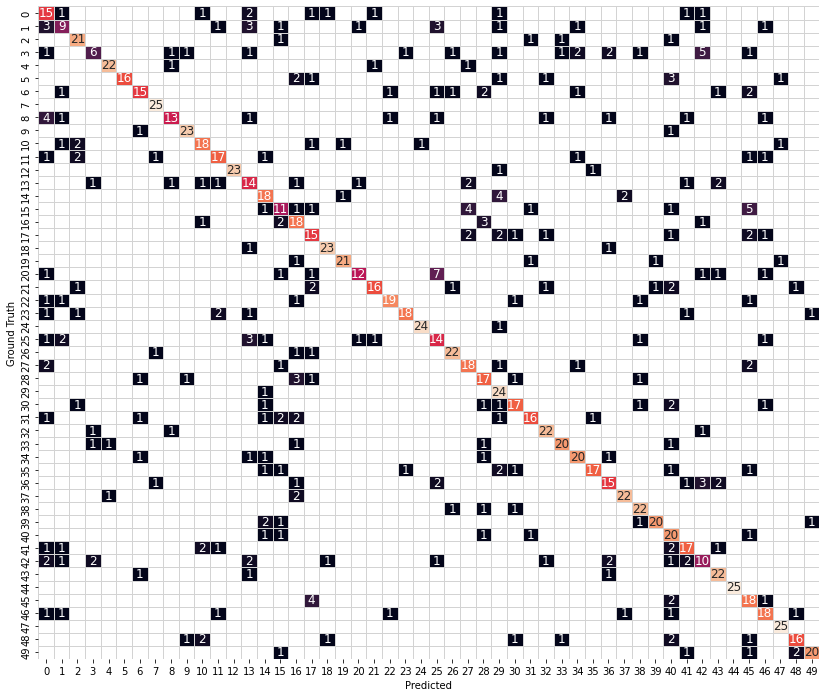

In [9]:
import torch
from src.predictor import predictor_test
from src.helpers import plot_confusion_matrix

model_reloaded = torch.jit.load("checkpoints/transfer_exported.pt")

pred, truth = predictor_test(data_loaders['test'], model_reloaded)

plot_confusion_matrix(pred, truth)